In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score, zero_one_loss, classification_report, confusion_matrix, precision_score, recall_score, f1_score,plot_roc_curve, plot_confusion_matrix

## Decision tree classifier and a random forest classifier
### Research question

#### Are decision trees and random forest good models for predicting whether someone will want more kids based on their age, ethinicity, work hours, and gender of their 1st child?

https://vincentarelbundock.github.io/Rdatasets/doc/AER/Fertility.html

A data frame containing 254,654 (and 30,000, respectively) observations on 8 variables.

morekids
factor. Does the mother have more than 2 children?

gender1
factor indicating gender of first child.

gender2
factor indicating gender of second child.

age
age of mother at census.

afam
factor. Is the mother African-American?

hispanic
factor. Is the mother Hispanic?

other
factor. Is the mother's ethnicity neither African-American nor Hispanic, nor Caucasian? (see below)

work
number of weeks in which the mother worked in 1979.

### Data pre-processing 

In [3]:
kids=pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/AER/Fertility.csv")
kids.drop(columns=['Unnamed: 0'], inplace=True)
kids[['morekids', 'afam', 'hispanic', 'other']]=kids[['morekids', 'afam', 'hispanic', 'other']].eq('yes').mul(1)
kids[['gender1', 'gender2']]=kids[['gender1', 'gender2']].eq('male').mul(1)
kids

,morekids,gender1,gender2,age,afam,hispanic,other,work
0,0,1,0,27,0,0,0,0
1,0,0,1,30,0,0,0,30
2,0,1,0,27,0,0,0,0
3,0,1,0,35,1,0,0,0
4,0,0,0,30,0,0,0,22
...,...,...,...,...,...,...,...,...
254649,1,0,0,35,0,0,0,0
254650,1,1,1,29,0,0,0,0
254651,1,0,1,34,0,0,0,38
254652,1,0,0,30,0,0,0,26


In [4]:
#Check for null values
kids.isnull().sum()

morekids    0
gender1     0
gender2     0
age         0
afam        0
hispanic    0
other       0
work        0
dtype: int64

In [5]:
# Understanding the different values for each column
columns=list(kids.columns)
for col in columns:
    print(col, ": ")
    print(kids[col].unique())
    print()

morekids : 
[0 1]

gender1 : 
[1 0]

gender2 : 
[0 1]

age : 
[27 30 35 26 29 33 28 34 32 24 31 21 25 23 22]

afam : 
[0 1]

hispanic : 
[0 1]

other : 
[0 1]

work : 
[ 0 30 22 40 52  8  7 20 12 37 42 51 17 21 34 50 48 36 49 26 18  4 32  5
  3  6 46  2 38 28 13 39 10 19 44 11 15 14 24 25 16  1  9 45 47 35 29 33
 43 23 41 27 31]



In [6]:
def gender (x):
    g=0
    if x[1]==1:
        if x[2]==1:
            g="MM"
            return g
        if x[2]==0:
            g="MF"
            return g
    if x[1]==0:
        if x[2]==1:
            g="MF"
            return g
        if x[2]==0:
            g="FF"
            return g
kids['genders']=kids.apply(gender, axis=1)
kids

,morekids,gender1,gender2,age,afam,hispanic,other,work,genders
0,0,1,0,27,0,0,0,0,MF
1,0,0,1,30,0,0,0,30,MF
2,0,1,0,27,0,0,0,0,MF
3,0,1,0,35,1,0,0,0,MF
4,0,0,0,30,0,0,0,22,FF
...,...,...,...,...,...,...,...,...,...
254649,1,0,0,35,0,0,0,0,FF
254650,1,1,1,29,0,0,0,0,MM
254651,1,0,1,34,0,0,0,38,MF
254652,1,0,0,30,0,0,0,26,FF


In [7]:
#Min max scaling for continuous data
cont=['age', 'work']
scaler = MinMaxScaler()
norm_kids=kids.copy()
norm_kids[cont] = scaler.fit_transform(norm_kids[cont])
# drop_first=True
norm_kids=pd.get_dummies(norm_kids, columns=['genders'])
norm_kids.drop(columns=['gender1', 'gender2'], inplace=True)
norm_kids

,morekids,age,afam,hispanic,other,work,genders_FF,genders_MF,genders_MM
0,0,0.428571,0,0,0,0.000000,0,1,0
1,0,0.642857,0,0,0,0.576923,0,1,0
2,0,0.428571,0,0,0,0.000000,0,1,0
3,0,1.000000,1,0,0,0.000000,0,1,0
4,0,0.642857,0,0,0,0.423077,1,0,0
...,...,...,...,...,...,...,...,...,...
254649,1,1.000000,0,0,0,0.000000,1,0,0
254650,1,0.571429,0,0,0,0.000000,0,0,1
254651,1,0.928571,0,0,0,0.730769,0,1,0
254652,1,0.642857,0,0,0,0.500000,1,0,0


In [8]:
norm_kids.describe()

,morekids,age,afam,hispanic,other,work,genders_FF,genders_MF,genders_MM
count,254654.000000,254654.000000,254654.000000,254654.000000,254654.000000,254654.000000,254654.000000,254654.000000,254654.000000
mean,0.380563,0.670948,0.051662,0.074207,0.056343,0.365737,0.239329,0.494432,0.266240
std,0.485526,0.241889,0.221345,0.262107,0.230584,0.420525,0.426675,0.499970,0.441992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.714286,0.000000,0.000000,0.000000,0.096154,0.000000,0.000000,0.000000
75%,1.000000,0.857143,0.000000,0.000000,0.000000,0.846154,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data splitting 

In [11]:
Xk= norm_kids.iloc[:,1:]
yk= norm_kids["morekids"]
Xk_train, Xk_rem, yk_train, yk_rem = train_test_split(Xk, yk, test_size=0.30, random_state=42)
Xk_val, Xk_test, yk_val, yk_test = train_test_split(Xk_rem, yk_rem, test_size=0.8, random_state=42)
print("Xk_train shape: ",Xk_train.shape)
print("Xk_train shape: ",Xk_val.shape)
print("Xk_test shape: ",Xk_test.shape)
print("yk_train shape: ",yk_train.shape)
print("yk_train shape: ",yk_val.shape)
print("yk_test shape: ",yk_test.shape)

Xk_train shape:  (178257, 8)
Xk_train shape:  (15279, 8)
Xk_test shape:  (61118, 8)
yk_train shape:  (178257,)
yk_train shape:  (15279,)
yk_test shape:  (61118,)


### Model construction (a decision tree and a random forest)

In [12]:
#Model construction (a decision tree)
from sklearn import tree
clfk = tree.DecisionTreeClassifier(random_state=42)
clfk = clfk.fit(Xk_train, yk_train)
yk_train_pred=clfk.predict(Xk_train)
yk_val_pred=clfk.predict(Xk_val)
print(accuracy_score(yk_train, yk_train_pred))
print(accuracy_score(yk_val, yk_val_pred))

0.6473742966615617
0.6225538320570718


In [13]:
maxDepthk=clfk.tree_.max_depth
maxDepthk

27

In [14]:
#Model construction (a random forest)
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(Xk_train, yk_train)
rf_y_train_pred=clf_rf.predict(Xk_train)
rf_y_val_pred=clf_rf.predict(Xk_val)
print(accuracy_score(yk_train, rf_y_train_pred))
print(accuracy_score(yk_val, rf_y_val_pred))

0.6473574670279428
0.620655802081288


In [15]:
maxDepthkrf=max([estimator.tree_.max_depth for estimator in clf_rf.estimators_])
maxDepthkrf

31

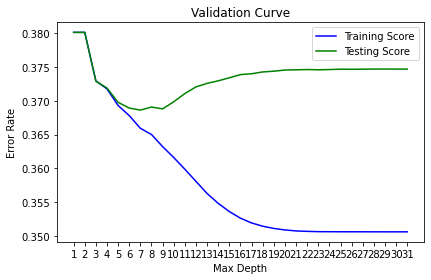

In [19]:
parameter_range = np.arange(1, maxDepthkrf+1)
train_scores, test_scores = validation_curve(
    clfk, Xk_train, yk_train, param_name="max_depth", param_range=parameter_range,
    scoring="accuracy")
train_scores_mean = 1-np.mean(train_scores, axis=1)
test_scores_mean = 1-np.mean(test_scores, axis=1)


plt.title("Validation Curve")
plt.xlabel("Max Depth")
plt.ylabel("Error Rate")
plt.xticks(np.arange(1, maxDepthkrf+1, step=1))
plt.tight_layout()
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, train_scores_mean,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, test_scores_mean,
   label = "Testing Score", color = 'g')
 
# Creating the plot
plt.legend(loc="best")
plt.show()

In [20]:
errorDf=pd.DataFrame(np.array([list(range(1, maxDepthkrf+1)), 
                               train_scores_mean, test_scores_mean]).T,
                    columns=["MaxDepth", "TrainingError", "TestingError"])
errorDf

,MaxDepth,TrainingError,TestingError
0,1.0,0.380125,0.380125
1,2.0,0.380125,0.380125
2,3.0,0.372942,0.372905
3,4.0,0.371755,0.371890
4,5.0,0.369305,0.369775
5,6.0,0.367807,0.368928
6,7.0,0.365934,0.368619
7,8.0,0.365015,0.369074
8,9.0,0.363221,0.368810
9,10.0,0.361606,0.369854


### Hyperparameter turning

#### Decision tree

In [21]:
param_gridk = {'max_depth':range(1, maxDepthk+1),'max_features':[0.2,0.4,0.6,0.8]}
clf = tree.DecisionTreeClassifier()
grid_searchk = GridSearchCV(clfk, param_gridk, cv=8)
grid_searchk.fit(Xk_train, yk_train)
grid_searchk.best_params_

{'max_depth': 9, 'max_features': 0.4}

In [22]:
1-grid_searchk.best_score_

0.36854652675278676

#### Random Forest

In [23]:
param_gridk = {'max_depth':np.arange(1, maxDepthkrf+1)}
grid_searchk = GridSearchCV(clf_rf, param_gridk, cv=3)
grid_searchk.fit(Xk_train, yk_train)
print(grid_searchk.best_estimator_)
1-grid_searchk.best_score_

RandomForestClassifier(max_depth=8, random_state=42)


0.36716089690727427

In [24]:
param_gridk = {'max_depth':[8], 'n_estimators': [10,50,100,200]}
grid_searchk = GridSearchCV(clf_rf, param_gridk, cv=3)
grid_searchk.fit(Xk_train, yk_train)
print(grid_searchk.best_estimator_)
1-grid_searchk.best_score_

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)


0.36702064996045036

In [25]:
param_gridk = {'max_depth':[8], 'n_estimators': [200,350,500]}
grid_searchk = GridSearchCV(clf_rf, param_gridk, cv=3)
grid_searchk.fit(Xk_train, yk_train)
print(grid_searchk.best_estimator_)
1-grid_searchk.best_score_

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)


0.36702064996045036

In [26]:
param_gridk = {'max_depth':[8], 'n_estimators': [200], 'max_features':[0.2,0.4,0.6,0.8]}
grid_searchk = GridSearchCV(clf_rf, param_gridk, cv=3)
grid_searchk.fit(Xk_train, yk_train)
print(grid_searchk.best_estimator_)
1-grid_searchk.best_score_

RandomForestClassifier(max_depth=8, max_features=0.4, n_estimators=200,
                       random_state=42)


0.36700943020470433

### Model Evaluation 

Decision tree

In [27]:
finalDT=tree.DecisionTreeClassifier(max_depth=9, max_features= 0.4, random_state=42)
finalDT.fit(Xk_train, yk_train)
finalDT_train_pred=finalDT.predict(Xk_train)
finalDT_test_pred=finalDT.predict(Xk_test)
print(accuracy_score(yk_train, finalDT_train_pred))
print(accuracy_score(yk_test, finalDT_test_pred))

0.6349371974172122
0.6301253313262869


Random Forest

In [28]:
finalRF=RandomForestClassifier(max_depth=8, max_features=0.4, n_estimators=200, random_state=42)
finalRF.fit(Xk_train, yk_train)
finalRF_train_pred=finalRF.predict(Xk_train)
finalRF_test_pred=finalRF.predict(Xk_test)
print(accuracy_score(yk_train, finalRF_train_pred))
print(accuracy_score(yk_test, finalRF_test_pred))

0.6360030742130743
0.6320560227756143


### Overfitting? Which model is better for classification for the dataset and why? 

There does not appear to be overfitting in any of the models. The accuracy score for training and test sets is similar. Decision tree is a simpler model. Also, decision tree takes up less resources. The accuracy scores for both models are similar. Decision tree appears to be the better model. Although normalization of the data and hyper parameter tuning was applied the metrics are not promising. The highest accuracy score achieved was of 63%. 